In [10]:
from SPARQLWrapper import JSON, POST, POSTDIRECTLY, SPARQLWrapper
import json
import pandas as pd
import os

ENDPOINT  = 'http://localhost:8080/sparql'

In [11]:
os.getcwd()

'/mnt/c/repos/rdf_permissions_example'

In [ ]:
def sparql_service_update(service, update_query):
    """
    Helper function to update (DELETE DATA, INSERT DATA, DELETE/INSERT) data.

    """
    sparql = SPARQLWrapper(service)
    sparql.setMethod(POST)
    sparql.setRequestMethod(POSTDIRECTLY)
    sparql.setQuery(update_query)
    sparql.query()

    # SPARQLWrapper is going to throw an exception if result.response.status != 200:

    return 'Done'

In [3]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.

    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)


In [ ]:
query = "LOAD /mnt/c/repos/rdf_permissions_example/data/graph_data.rdf"

result = sparql_service_update(ENDPOINT, query)
result

In [5]:
query = """select * where {?s ?p ?o .} limit 10"""
result = sparql_service_to_dataframe(ENDPOINT, query)
result

,s,p,o
0,b518,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#country
1,b519,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#managedBy
2,b520,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#manages...
3,b521,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#item
4,b522,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#country
5,b523,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#managedBy
6,b524,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#item
7,b525,http://www.w3.org/1999/02/22-rdf-syntax-ns#first,local://security.permissions.net/vocab#manages...
8,b518,http://www.w3.org/1999/02/22-rdf-syntax-ns#rest,http://www.w3.org/1999/02/22-rdf-syntax-ns#nil
9,b519,http://www.w3.org/1999/02/22-rdf-syntax-ns#rest,b520


In [8]:
# Since we haven't run ontological reasoning yet, the "manages" relationships are not inferred
query = """
PREFIX : <local://security.permissions.net/vocab#>

SELECT ?s ?p ?o
WHERE {
  ?s ?p ?o .
  FILTER(?p = :manages || ?p = :managesDepartment) .
}

"""

# Execute the query
result = sparql_service_to_dataframe(ENDPOINT, query)
result

,s,p,o
0,local://security.permissions.net/entities#Steve,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#KITCHEN
1,local://security.permissions.net/entities#Mary,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#CHRI...
2,local://security.permissions.net/entities#Mary,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#BIRT...
3,local://security.permissions.net/entities#John,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#OFFICE
4,local://security.permissions.net/entities#John,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#HOBBY
5,local://security.permissions.net/entities#Sama...,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#HOME...
6,local://security.permissions.net/entities#Jackson,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#APPAREL
7,local://security.permissions.net/entities#Anya,local://security.permissions.net/vocab#manages...,local://security.permissions.net/entities#STORAGE


### The next query with inference rules should return the following triples:
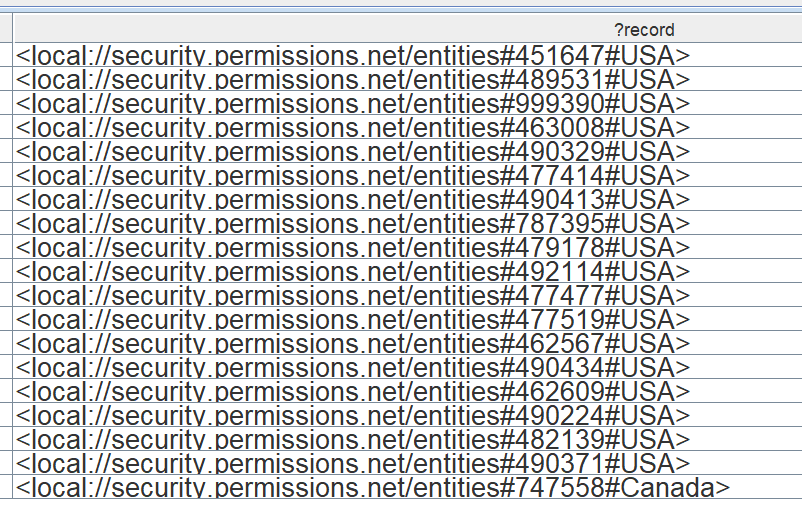

In [ ]:
# Since we haven't run ontological reasoning yet, the "manages" relationships are not inferred
query = """
prefix data: <local://security.permissions.net/entities#>
prefix : <local://security.permissions.net/vocab#>

select ?record where {
data:SalesRep_45 a :User ; :hasAccess ?country, ?department .
?department a :Department .
?country a :Country .
?department :hasItem ?item .
?record a :Record; :country ?country; :item ?item.
}
"""

# Execute the query
result = sparql_service_to_dataframe(ENDPOINT, query)
result

,country,department,item,record
